In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('wordnet')
import gensim
import string
from wordcloud import WordCloud
from PIL import Image
import collections

[nltk_data] Downloading package wordnet to /home/quadm/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [79]:
def hasNumber(word):
    return any(char.isdigit() for char in word)
      
def preprocess(textfile):
    with open(textfile, 'r') as reader:
        text = reader.read()
    text = text.lower()     # Make all text lowercase
    nopunct="".join([char for char in text if char not in string.punctuation]) # Remove all punctuation
    tokens = nltk.tokenize.word_tokenize(nopunct) # Tokenize
    nonums = [t for t in tokens if not hasNumber(t)]  # Remove all numbers
    
    lemmatizer = nltk.stem.WordNetLemmatizer()
    
    lemmatized = [lemmatizer.lemmatize(t, pos="v") for t in nonums] # Lemmatize words (One way to stem)
    return [t for t in lemmatized if t not in nltk.corpus.stopwords.words('english')] # Remove stopwords

tokenized = preprocess('data/C50train/AlanCrosby/10306newsML.txt')

In [85]:
frequency = collections.Counter(tokenized)
print(frequency)

Counter({'point': 12, 'week': 11, 'price': 11, 'index': 10, 'close': 10, 'market': 10, 'stock': 9, 'share': 8, 'trade': 8, 'thursday': 7, 'say': 7, 'exchange': 6, 'gain': 5, 'percent': 5, 'last': 5, 'investors': 5, 'prague': 4, 'bratislava': 4, 'rise': 4, 'sofia': 4, 'ljubljana': 4, 'firm': 4, 'july': 4, 'european': 3, 'though': 3, 'warsaw': 3, 'budapest': 3, 'post': 3, 'cesi': 3, 'czech': 3, 'steady': 3, 'holiday': 3, 'spt': 3, 'banka': 3, 'real': 3, 'analysts': 3, 'trend': 3, 'seem': 3, 'several': 3, 'high': 3, 'weeks': 3, 'tuesday': 3, 'bse': 3, 'sax': 3, 'central': 2, 'bucharest': 2, 'zagreb': 2, 'mix': 2, 'one': 2, 'cloud': 2, 'movements': 2, 'polish': 2, 'monday': 2, 'lead': 2, 'saw': 2, 'issue': 2, 'crown': 2, 'session': 2, 'lose': 2, 'final': 2, 'sykora': 2, 'company': 2, 'participants': 2, 'bourse': 2, 'fact': 2, 'foreign': 2, 'show': 2, 'growth': 2, 'buyers': 2, 'bank': 2, 'sa': 2, 'earn': 2, 'wig': 2, 'return': 2, 'us': 2, 'securities': 2, 'bux': 2, 'dominate': 2, 'low': 2, 

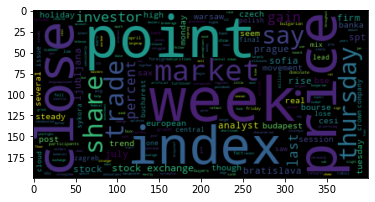

In [82]:
plt.imshow(wc1, interpolation='bilinear')